In [1]:
## call the main routines
using NBInclude
@nbinclude("core_fun.ipynb");

We fix the parameters for the case of Germany in an object of type Country. The calibrated values for $\alpha$, $m$, $q$, $\lambda_{min}$ and $\lambda_{max}$ are obtained latter on.

In [2]:
germany = let 
    
    reform = 2
    A = 42. * 12
    Amin = 38. * 12
    Amax = 44. * 12
    
    r = 0.0048 # 5 % annual interest rate, time unit = month
    c0 = 1. # scale parameter of the cost function, normalized to 1

    ### to be updated after the calibration
    alpha, m, q = 0.7 , 0.1, 0.03
    lambdamin = 0.07
    lambdamax = lambdamin + 0.03
    
    uinit = [0.,0.] ## useless parameters
    
    wbar = 1.
    bUI = 0.68 * wbar  # replacement rate for individual with children 68 (without children is 63) , SVB2012a
    b0max = 0.35 * wbar # 35% social assistance for married individuals, SVB2012a
    b0min = b0max
    
    Country(reform,A,Amin,Amax,r,c0,alpha,q,m,lambdamin,lambdamax,uinit,bUI,b0max,b0min,wbar)
end
;

In [3]:
## precompile functions
let 
    a=41.8*12
    B=6.2
    D=15.4
    simu = find_simu(germany,reltol=1e-5) 
    @time fUI(B, a, simu,germany) 
    @time expectedB(a, simu,germany)
    @time integrand_fNE(B, D, a,simu, germany)
    @time fNE(D, a, simu, germany) 
    @time expectedD(a, simu, germany)
    @time averageU5(0.025, 0.07, 0.0537, germany) 
end

  2.984247 seconds (5.86 M allocations: 295.838 MiB, 7.30% gc time)
  0.395519 seconds (1.53 M allocations: 49.306 MiB, 5.36% gc time)
  0.475201 seconds (648.24 k allocations: 31.982 MiB, 2.02% gc time)
  0.445893 seconds (979.49 k allocations: 40.128 MiB, 4.48% gc time)
 12.054767 seconds (119.55 M allocations: 2.044 GiB, 4.84% gc time)
  7.325434 seconds (85.43 M allocations: 1.626 GiB, 5.84% gc time)


29.12427721560897

# 1) Find the parameters
We take as moments the expected duration of nonemployment and UI, and the cumulated duration of nonemployment.

In [4]:
function moments_germany(simu::Simu,C::Country)
    momD1 = expectedD(41.99*12,simu,C)
    momD2 = expectedD(42.01*12,simu,C)
    jfr0 = JFrate(simu.Ybar[1],C)
    jfrUI = JFrate(simu.Ybar[3],C)
    momav = averageU5(C.q, jfr0, jfrUI, C) 
    momB1 = expectedB(41.99*12,simu,C)
    momB2 = expectedB(42.01*12,simu,C)
    return([momD1, momD2, momav, momB1, momB2])
end

moments_target = [15.6, 16.4, (892.9+28/2)/365*12, 6.7, 8.5] 

function distance(m1,m2)
    out = 0
    for i in 1:length(m1)
        out += (m1[i] - m2[i]) ^2
    end
    return(out)
end

distance (generic function with 1 method)

We calibrate our model to determine the values of $\alpha$, $m$, $q$, $\lambda_{min}$ and $\lambda_{max}$.

In [5]:
## generate a Country object with new values for alpha, m, q , lambdamin and lambdamin+diff
function update_Country(alpha,m,q,lambdamin,lambdadiff, C::Country)
    Country(C.reform,C.A,C.Amin,C.Amax,C.r,C.c0,
        alpha,q, m, lambdamin, lambdamin+lambdadiff,
        C.uinit,C.bUI,C.b0max,C.b0min,C.wbar)
end

## compute the objective to minimise
function objective_ger(alpha,m,q,lambdamin,lambdadiff, C::Country)
    newC = update_Country(alpha,m,q,lambdamin,lambdadiff, C)

    ## simulate
    simu = find_simu(newC,reltol=1e-5) 
    moments_emp = moments_germany(simu,newC)
    
    IJulia.clear_output(true)
    println(alpha," ",m," ",q)
    println(moments_emp)
    
    distance(moments_emp, moments_target)
end

## distance minimisation with NLopt (/!\ time-consuming)
@time parmin = let
    opt = Opt(:LN_BOBYQA, 5)
    lower_bounds!(opt, [0.1 , 0.,0., 0., 0.])
    upper_bounds!(opt, [10. , 1.,0.2, 0.2, 1.])
    xtol_rel!(opt,1e-8)
    stopval!(opt,1e-8)
    min_objective!(opt, (v,g)-> objective_ger(v[1],v[2],v[3],v[4],v[5],germany))

    init = [0.7, 0.1, 0.025, 0.06, 0.03]

    (minf,minx,ret) = optimize(opt, init) 
    println("Param found with convergence ", ret, ", the value of the objective is ",minf)
    println(minx[1], "  ",minx[2],"  ",minx[3])
    minx
end

germany = update_Country(parmin[1],parmin[2],parmin[3],parmin[4],parmin[5], germany)

0.7070581923764002 0.10766368903230991 0.025922181570158468
[15.5819, 16.4215, 29.8136, 6.7046, 8.48975]
Param found with convergence SUCCESS, the value of the objective is 0.000921808308576857
0.7070581913467943  0.10766368910270101  0.02592218152022622
3222.075404 seconds (38.26 G allocations: 698.420 GiB, 6.55% gc time)


Country(2, 504.0, 456.0, 528.0, 0.0048, 1.0, 0.7070581913467943, 0.02592218152022622, 0.10766368910270101, 0.0666660972208511, 0.09447973131417307, [0.0, 0.0], 0.68, 0.35, 0.35, 1.0, 0.0008950554291787007, 0.020071223282296706)

# 2) Simulation

In [6]:
simu_ger = find_simu(germany,reltol=1e-5)
println("We print the targetted and simulated moments:")
hcat(moments_germany(simu_ger,germany), moments_target)

We print the targetted and simulated moments:


5×2 Array{Float64,2}:
 15.5819   15.6   
 16.4215   16.4   
 29.8136   29.8159
  6.7046    6.7   
  8.48975   8.5   

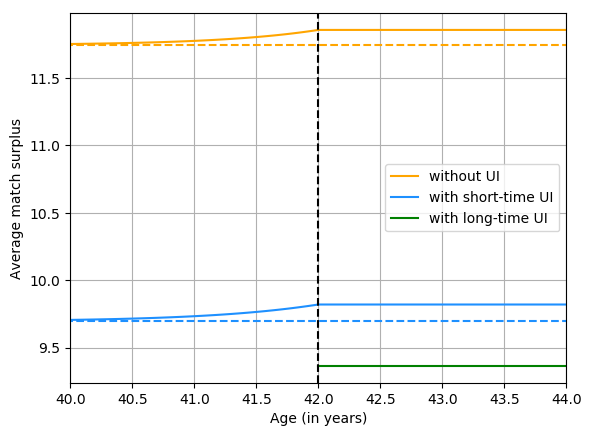

--- GRAPH DESCRIPTION ---
The blue continuous curve represents the match surplus when a worker receives UI benefits for a shorter entitlement period.
The orange continuous curve represents the match surplus when a worker only receives the social assistance.
The green curve represents the match surplus when a worker receives UI benefits for a longer entitlement period.
The dashed curves are the curves under the counterfactual situation.
-----


In [7]:
simuplot_surplus(simu_ger,germany, xaxis=[40,44]*12)

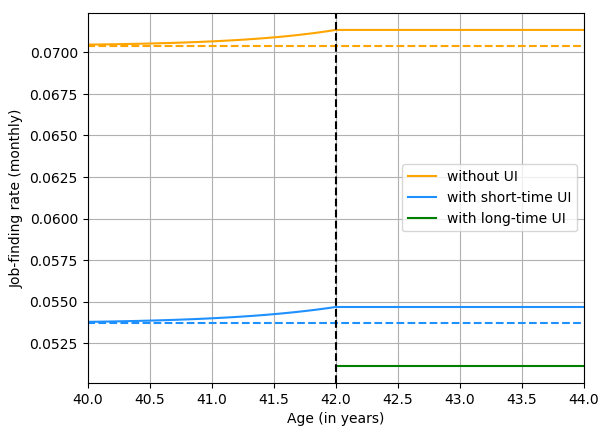

--- GRAPH DESCRIPTION ---
The blue continuous curve represents the job-finding rate when a worker receives UI benefits for a shorter entitlement period.
The orange continuous curve represents the job-finding rate when a worker only receives the social assistance.
The green curve represents the job-finding rate when a worker receives UI benefits for a longer entitlement period.
The dashed curves are the curves under the counterfactual situation.
-----


In [8]:
simuplot_JF(simu_ger,germany, xaxis=[40,44]*12)

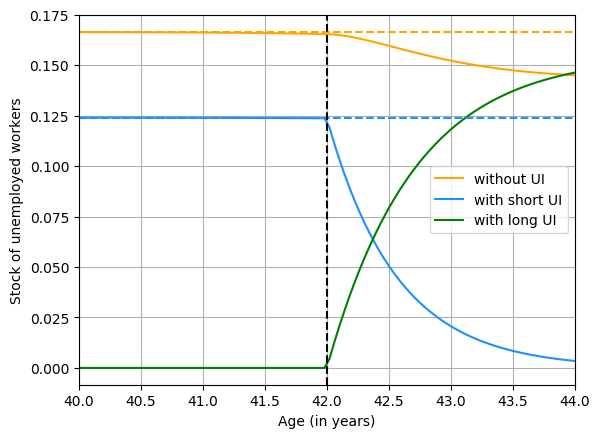

--- GRAPH DESCRIPTION ---
The blue continuous curve represents the unemployment rate with short-time UI benefits.
The orange continuous curve represents the uemplpoyment rate under the social assistance.
The green curve represents the unemployment rate with long-time UI benefits.
The dashed curves give the counterfactual dynamics without a policy change.
-----


In [9]:
unemp_ger = find_unemp(simu_ger, germany, unitSS = true) 
unemp_ger_counter0 = find_unemp_counter0(simu_ger, germany, unitSS = true) 
unemp_ger_counter1 = find_unemp_counter1(simu_ger, germany, unitSS = true) 
simuplot_unemp(unemp_ger,unemp_ger_counter0,germany, xaxis=[40.,44]*12)

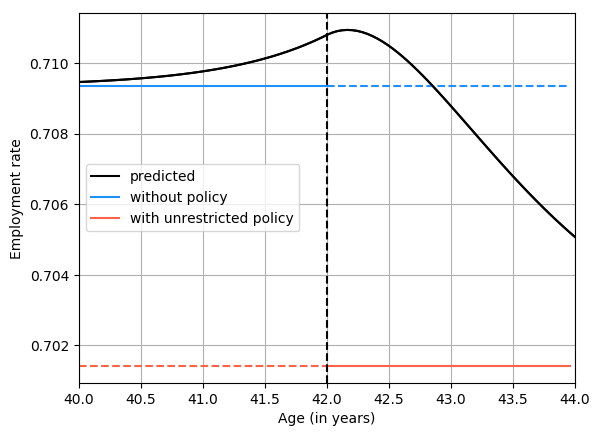

In [10]:
simuplot_emp_withpoints(unemp_ger,unemp_ger_counter0,unemp_ger_counter1,[],[], germany, xaxis=[40.,44.]*12) #, yaxis=[0.7475,0.76])

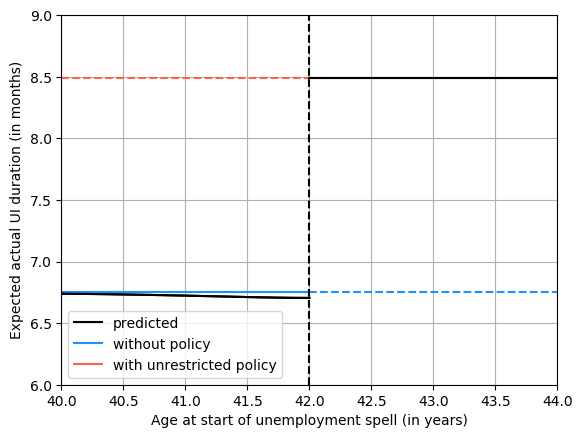

In [11]:
simuplot_B(simu_ger, germany, xaxis=[40. *12,44. *12],yaxis=[6,9])

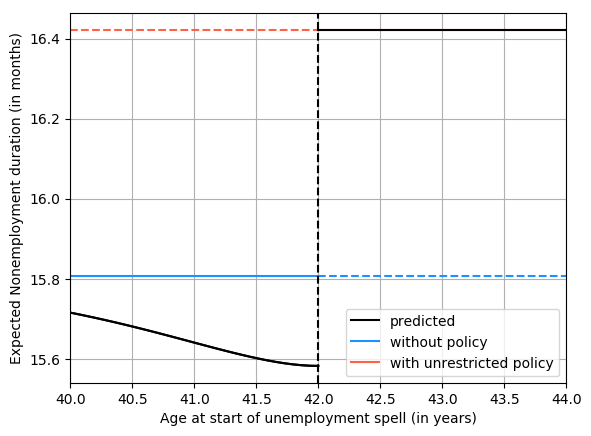

In [12]:
simuplot_D(simu_ger, germany, xaxis=[40. *12,44. *12]) #,yaxis=[6.,9.5])

# 3) RDD with simulated model

In [13]:
table = zeros(4,2)

## simulated data at dayly frequency with different bandwidths
for (i,band) in enumerate([2.,1.,0.5,0.2])

    age_grid = (germany.A/12-band):(1/365):(germany.A/12+band)
    Y1 = [expectedB(m,simu_ger,germany) for m in 12*age_grid] 
    Y2 = [expectedD(m,simu_ger,germany) for m in 12*age_grid] 


    #explaining variables
    TREAT = [a>=germany.A for a in age_grid*12]
    consta = ones(size(age_grid))
    age1 = collect(age_grid*12)
    age1_spl = (age1 .- germany.A) .* TREAT 

    ## linear spline
    X = hcat(TREAT, consta, age1, age1_spl )   
    beta1 = inv(X' * X) * (X' * Y1)
    beta2 = inv(X' * X) * (X' * Y2)
    table[i,1] = beta1[1] 
    table[i,2] = beta2[1] 

end    

table

4×2 Array{Float64,2}:
 1.78687  0.852932
 1.78743  0.847878
 1.78621  0.842669
 1.78541  0.840254

In [14]:
## simulated effect of the policy
mu0 = JFrate(simu_ger.Ybar[4],germany)
muUI = JFrate(simu_ger.Ybar[5],germany) 
lam = germany.lambdamax
expDcounter0 = ((mu0-muUI)/((lam+muUI)*(mu0-lam-muUI)) - lam/(mu0*(mu0-lam-muUI)))
expDcounter1 = expectedD(germany.Amax,simu_ger,germany)

expBcounter0 = 1/ (germany.lambdamax+JFrate(simu_ger.Ybar[5],germany))
expBcounter1 = expectedB(germany.Amax,simu_ger,germany)

println("The simulated model gives 2 LATEs at ")
[(expBcounter1-expBcounter0) ,(expDcounter1-expDcounter0)]

The simulated model gives 2 LATEs at 


2-element Array{Float64,1}:
 1.7406424914000356
 0.61431360792578  

# 4) 3D plot

In [15]:
n=50
i=0
out = zeros(n^2,3)
C=germany
for mdec in range(-1,stop=2,length=n), qdec in range(-1,stop=1,length=n)
        i +=1
        newC = Country(C.reform,C.A,C.Amin,C.Amax,C.r,C.c0,C.alpha,
                C.q*10^qdec, C.m*10^mdec,
                C.lambdamin,C.lambdamax,C.uinit,C.bUI,C.b0max,C.b0min,C.wbar)
        simu =  find_simu(newC,reltol=1e-4)
        out[i,:] = [mdec, qdec, JFrate(simu.Xbar2(C.A),newC)-JFrate(simu.Ybar[5],newC)  ]
end

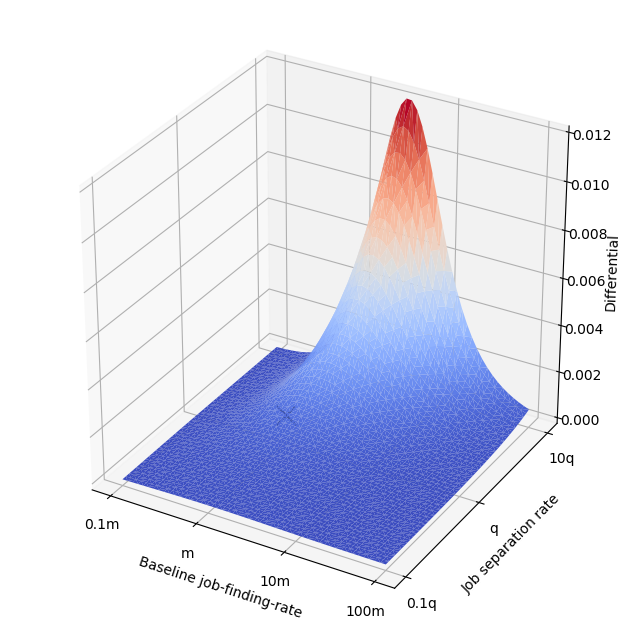

(PyCall.PyObject[PyObject <matplotlib.axis.XTick object at 0x0000000033D8AB38>, PyObject <matplotlib.axis.XTick object at 0x0000000033D8AD68>, PyObject <matplotlib.axis.XTick object at 0x0000000033DCD470>], PyCall.PyObject[PyObject Text(0.027692564538341978, -0.08618504995699079, '0.1q'), PyObject Text(0.049392549231486865, -0.0636509500288674, 'q'), PyObject Text(0.06966705245025401, -0.04259712496930023, '10q')])

In [16]:
figure(figsize=(8,8))
surf(out[:,1],out[:,2],out[:,3], cmap = "coolwarm")
scatter3D(0, 0, JFrate(simu_ger.Xbar2(germany.A),germany)-JFrate(simu_ger.Ybar[5],germany), s=200, color="black", marker="x")
xlabel("Baseline job-finding-rate")
ylabel("Job separation rate")
zlabel("Differential")
zlim([0,0.012])
xticks([-1,0,1,2], ["0.1m","m","10m","100m"])
yticks([-1,0,1], ["0.1q","q","10q"])


In [17]:
JFrate(simu_ger.Xbar2(germany.A),germany)-JFrate(simu_ger.Ybar[5],germany)

0.0009837942398901803